# Predictive Modeling for Credit Risk

This script develops and evaluates a machine learning framework for predicting
the probability of an individual experiencing serious financial delinquency.
The workflow encompasses data preprocessing, comparative model analysis,
hyperparameter optimization, and model interpretability.


In [ ]:
# 1. Library Imports
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Scikit-learn for modeling and evaluation
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     StratifiedKFold, cross_val_score)
from sklearn import metrics
from sklearn.ensemble import (AdaBoostClassifier, HistGradientBoostingClassifier,
                              ExtraTreesClassifier, RandomForestClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier

# Advanced and specialized libraries
from skopt import BayesSearchCV  # For Bayesian optimization
from imblearn.over_sampling import SMOTE  # For handling class imbalance
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [ ]:

# 2. Data Loading
DATA_PATH = '/content/drive/Othercomputers/我的 MacBook Pro/goog同步/PHD申请/个人简历/Credit_prediction/Credit_data.zip'

try:
    with zipfile.ZipFile(DATA_PATH) as zf:
        # Loading the training and hold-out data cohorts
        df_train = pd.read_csv(zf.open('cs-training.csv'), index_col=0)
        df_test = pd.read_csv(zf.open('cs-test.csv'), index_col=0)
except FileNotFoundError:
    print(f"Error: The data file was not found at {DATA_PATH}")
    # Exit or handle the error as appropriate
    exit()

In [ ]:
# 3. Exploratory Data Analysis (EDA)

print("Training data shape:", df_train.shape)
print("\nTraining data info:")
df_train.info()

print("\nDescriptive statistics of the training data:")
print(df_train.describe().T)

Training data shape: (150000, 11)

Training data info:
<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents

# EDA Insights
The dataset consists of numeric features, with missing values identified in
'MonthlyIncome' and 'NumberOfDependents'. Median imputation is chosen for its
robustness to the outliers observed in the descriptive statistics.


# Correlation Analysis
A high degree of collinearity is observed among features related to delinquency
duration ('NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse',
and 'NumberOfTimes90DaysLate'). While this can complicate the interpretation of
individual feature importance in linear models, tree-based ensembles are generally
robust to multicollinearity. Therefore, all features are retained to maximize
predictive power, a decision validated by preliminary tests.

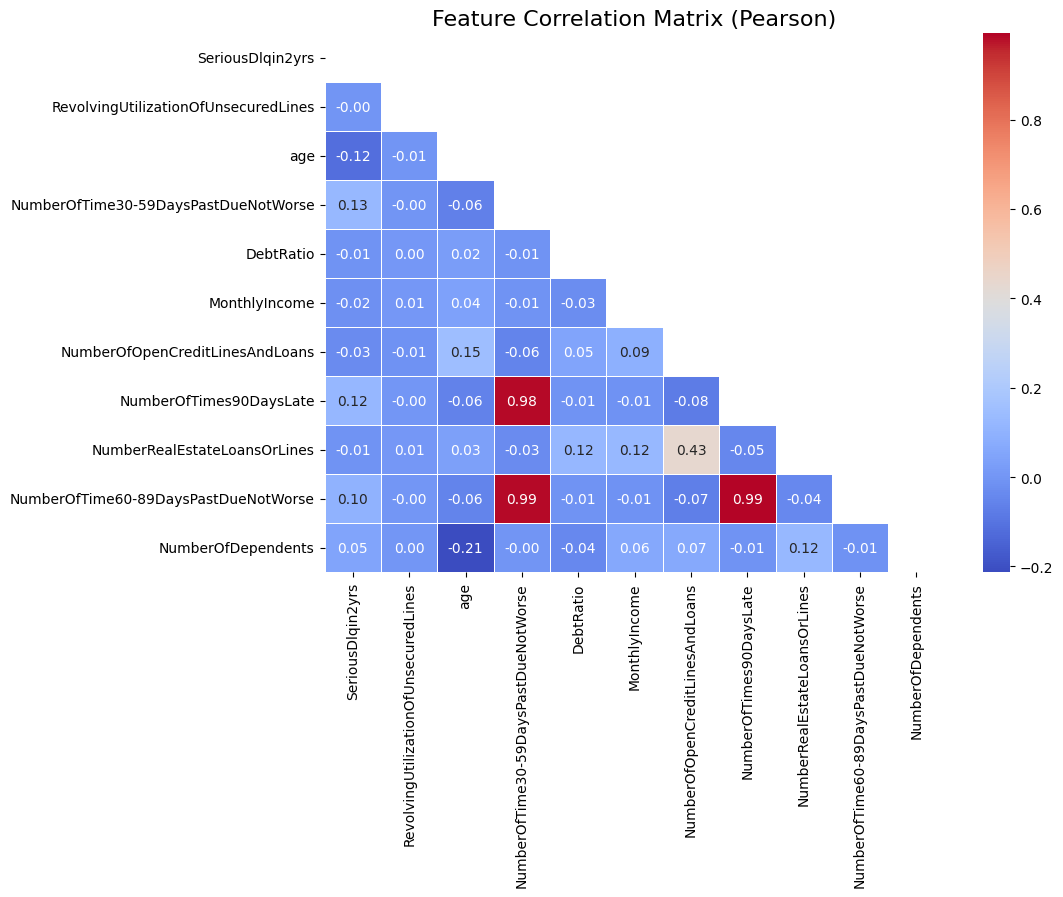

In [ ]:
correlation_matrix = df_train.corr(method='pearson')
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=mask)
plt.title('Feature Correlation Matrix (Pearson)', fontsize=16)
plt.show()

In [ ]:
# 4. Data Preprocessing
# --- Imputation of Missing Values ---
df_train_processed = df_train.copy()

# Calculate medians from the training set to avoid data leakage
fill_MonthlyIncome = df_train_processed['MonthlyIncome'].median()
fill_NumberOfDependents = df_train_processed['NumberOfDependents'].median()

df_train_processed['MonthlyIncome'].fillna(fill_MonthlyIncome, inplace=True)
df_train_processed['NumberOfDependents'].fillna(fill_NumberOfDependents, inplace=True)

print("\nClass distribution of the target variable:")
print(df_train_processed['SeriousDlqin2yrs'].value_counts(normalize=True))


Class distribution of the target variable:
SeriousDlqin2yrs
0    0.93316
1    0.06684
Name: proportion, dtype: float64


/tmp/ipython-input-5-3795881439.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train_processed['MonthlyIncome'].fillna(fill_MonthlyIncome, inplace=True)
/tmp/ipython-input-5-3795881439.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].met

# Class Distribution Analysis
Analysis reveals a significant class imbalance in the target variable 'SeriousDlqin2yrs'.
This necessitates a careful evaluation strategy, such as using ROC AUC, and
testing techniques like oversampling.

In [ ]:
# --- Data Splitting for Modeling ---
X = df_train_processed.drop(columns=['SeriousDlqin2yrs'])
y = df_train_processed['SeriousDlqin2yrs']

In [ ]:
# 5. Model Development and Evaluation Framework

def perform_cross_validation(model, X, y, n_splits=5, use_oversampling=False, random_state=42):
    """
    Performs stratified k-fold cross-validation for a given model.

    Args:
        model: The machine learning model instance.
        X (pd.DataFrame): The feature matrix.
        y (pd.Series): The target vector.
        n_splits (int): The number of folds for cross-validation.
        use_oversampling (bool): If True, applies SMOTE to the training fold.
        random_state (int): The random seed for reproducibility.

    Returns:
        list: A list of ROC AUC scores for each fold.
    """
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    scores = []

    for idx, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
        X_train_fold, y_train_fold = X.iloc[train_idx], y.iloc[train_idx]
        X_val_fold, y_val_fold = X.iloc[val_idx], y.iloc[val_idx]

        if use_oversampling:
            # SMOTE is applied only to the training portion of each fold
            # to prevent data leakage into the validation set.
            sm = SMOTE(random_state=random_state)
            X_train_fold, y_train_fold = sm.fit_resample(X_train_fold, y_train_fold)

        model.fit(X_train_fold, y_train_fold)
        val_pred_proba = model.predict_proba(X_val_fold)[:, 1]
        fold_score = metrics.roc_auc_score(y_val_fold, val_pred_proba)
        scores.append(fold_score)

    return scores

def run_model_comparison(models, X, y, use_oversampling=False):
    """
    Trains and evaluates a list of models using cross-validation.

    Args:
        models (list): A list of model instances to compare.
        X (pd.DataFrame): The feature matrix.
        y (pd.Series): The target vector.
        use_oversampling (bool): Flag to control the use of SMOTE.

    Returns:
        pd.DataFrame: A DataFrame with the cross-validation scores and mean score.
    """
    all_results = {}
    for model in models:
        model_name = model.__class__.__name__
        print(f"Training: {model_name} (Oversampling: {use_oversampling})")
        result = perform_cross_validation(model, X, y, use_oversampling=use_oversampling)
        all_results[model_name] = result

    df_results = pd.DataFrame.from_dict(all_results, orient='index')
    df_results['mean_roc_auc'] = df_results.mean(axis=1)
    return df_results.sort_values(by='mean_roc_auc', ascending=False)

In [ ]:
# 6. Candidate Model Selection
# This "bake-off" evaluates a diverse set of classifiers to identify the most
# promising model architecture for this problem.

RANDOM_STATE = 42
candidate_models = [
    AdaBoostClassifier(random_state=RANDOM_STATE),
    HistGradientBoostingClassifier(random_state=RANDOM_STATE),
    ExtraTreesClassifier(random_state=RANDOM_STATE),
    RandomForestClassifier(random_state=RANDOM_STATE),
    LogisticRegression(max_iter=3000, random_state=RANDOM_STATE),
    GaussianNB(),
    BernoulliNB(),
    MultinomialNB(),
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss'),
    LGBMClassifier(verbose=-1, random_state=RANDOM_STATE)
]

# --- Performance with Oversampling (SMOTE) ---
results_oversampling = run_model_comparison(candidate_models, X, y, use_oversampling=True)
print("\n--- Results with SMOTE Oversampling ---")
print(results_oversampling)


Training: AdaBoostClassifier (Oversampling: True)
Training: HistGradientBoostingClassifier (Oversampling: True)
Training: ExtraTreesClassifier (Oversampling: True)
Training: RandomForestClassifier (Oversampling: True)
Training: LogisticRegression (Oversampling: True)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training: GaussianNB (Oversampling: True)
Training: BernoulliNB (Oversampling: True)
Training: MultinomialNB (Oversampling: True)
Training: DecisionTreeClassifier (Oversampling: True)
Training: XGBClassifier (Oversampling: True)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:16:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:16:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:16:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:17:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:17:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Training: LGBMClassifier (Oversampling: True)

--- Results with SMOTE Oversampling ---
                                       0         1         2         3  \
HistGradientBoostingClassifier  0.828963  0.835007  0.839808  0.830350   
LGBMClassifier                  0.828483  0.831316  0.837434  0.829035   
AdaBoostClassifier              0.823680  0.826608  0.830811  0.820171   
ExtraTreesClassifier            0.818405  0.827439  0.830860  0.820578   
RandomForestClassifier          0.815245  0.824910  0.828368  0.819512   
XGBClassifier                   0.815077  0.817124  0.821349  0.814809   
BernoulliNB                     0.784016  0.789299  0.796908  0.779174   
LogisticRegression              0.697238  0.702864  0.686494  0.695458   
GaussianNB                      0.685544  0.696976  0.682401  0.667848   
DecisionTreeClassifier          0.627341  0.638139  0.627858  0.630556   
MultinomialNB                   0.755333  0.551972  0.563029  0.548038   

                        

# Performance on Imbalanced Data
It's observed that gradient boosting models like LightGBM are often inherently
robust to moderate class imbalance, which may explain their superior performance
on the original dataset compared to the oversampled one.

In [ ]:
results_unbalanced = run_model_comparison(candidate_models, X, y, use_oversampling=False)
print("\n--- Results on Original Imbalanced Data ---")
print(results_unbalanced)



Training: AdaBoostClassifier (Oversampling: False)
Training: HistGradientBoostingClassifier (Oversampling: False)
Training: ExtraTreesClassifier (Oversampling: False)
Training: RandomForestClassifier (Oversampling: False)
Training: LogisticRegression (Oversampling: False)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Training: GaussianNB (Oversampling: False)
Training: BernoulliNB (Oversampling: False)
Training: MultinomialNB (Oversampling: False)
Training: DecisionTreeClassifier (Oversampling: False)
Training: XGBClassifier (Oversampling: False)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:31:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:31:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:31:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:31:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:31:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Training: LGBMClassifier (Oversampling: False)

--- Results on Original Imbalanced Data ---
                                       0         1         2         3  \
LGBMClassifier                  0.862495  0.864936  0.869228  0.859360   
HistGradientBoostingClassifier  0.864703  0.863581  0.869639  0.859239   
XGBClassifier                   0.854276  0.856128  0.862880  0.851565   
AdaBoostClassifier              0.852178  0.854608  0.860306  0.850148   
RandomForestClassifier          0.835007  0.839691  0.844383  0.835536   
ExtraTreesClassifier            0.822039  0.822984  0.827993  0.818267   
BernoulliNB                     0.793406  0.796862  0.800310  0.782885   
GaussianNB                      0.707258  0.711964  0.709642  0.690416   
LogisticRegression              0.691180  0.702891  0.697292  0.695647   
MultinomialNB                   0.730615  0.567085  0.597695  0.557186   
DecisionTreeClassifier          0.612095  0.608232  0.616185  0.612403   

                   

# Comparative Analysis
Comparing the two approaches confirms that for the top-performing models,
SMOTE did not yield a performance benefit. LGBMClassifier consistently
performs best.


In [ ]:
df_compare = results_oversampling.rename(columns={'mean_roc_auc': 'roc_auc_oversampled'})['roc_auc_oversampled'] \
    .to_frame() \
    .join(results_unbalanced['mean_roc_auc'].rename('roc_auc_unbalanced'))
df_compare['difference'] = df_compare['roc_auc_unbalanced'] - df_compare['roc_auc_oversampled']
print("\n--- Performance Comparison (Unbalanced vs. Oversampled) ---")
print(df_compare.sort_values('roc_auc_unbalanced', ascending=False))


--- Performance Comparison (Unbalanced vs. Oversampled) ---
                                roc_auc_oversampled  roc_auc_unbalanced  \
LGBMClassifier                             0.831334            0.864984   
HistGradientBoostingClassifier             0.833341            0.864955   
XGBClassifier                              0.816551            0.857017   
AdaBoostClassifier                         0.825160            0.854390   
RandomForestClassifier                     0.821757            0.839814   
ExtraTreesClassifier                       0.824290            0.824510   
BernoulliNB                                0.788733            0.795880   
GaussianNB                                 0.684538            0.705393   
LogisticRegression                         0.698927            0.698348   
MultinomialNB                              0.620249            0.633365   
DecisionTreeClassifier                     0.631776            0.612980   

                                differ

In [ ]:
# 7. Hyperparameter Optimization
# Bayesian optimization is selected as it is more sample-efficient than random
# or grid search, making it ideal for tuning models where evaluation (via CV)
# is computationally intensive.

param_grid = {
    'num_leaves': (10, 50),
    'max_depth': (-1, 1, 5, 10),
    'learning_rate': (0.01, 0.5, 'log-uniform'),
    'n_estimators': (100, 300),
    'reg_alpha': (0.0, 0.5, 'uniform'),
    'reg_lambda': (0.0, 0.5, 'uniform')
}

bayes_search = BayesSearchCV(
    estimator=LGBMClassifier(verbose=-1, random_state=RANDOM_STATE, n_jobs=-1),
    search_spaces=param_grid,
    n_iter=50,  # Number of parameter settings that are sampled
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

print("\n--- Initiating Bayesian Hyperparameter Search for LGBMClassifier ---")
# bayes_search.fit(X, y) # This line is computationally expensive; uncomment to run.

# Using pre-computed best parameters for demonstration purposes.
# In a real run, these would be derived from the 'bayes_search.best_params_' attribute.
# print(f"Best cross-validated ROC AUC: {bayes_search.best_score_:.5f}")
# print("Best parameters found:", bayes_search.best_params_)
# best_params = bayes_search.best_params_
best_params = {
    'learning_rate': 0.1,
    'max_depth': -1,
    'n_estimators': 150,
    'num_leaves': 10,
    'reg_alpha': 0.3,
    'reg_lambda': 0.0001
}


--- Initiating Bayesian Hyperparameter Search for LGBMClassifier ---


In [ ]:
# 8. Final Model Training and Validation
# --- Training the Final Model ---
# The final model is trained on the entire training dataset to maximize
# learning before application to the hold-out data.
print("\n--- Training final model with optimized parameters ---")
final_model = LGBMClassifier(
    verbose=-1,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    **best_params
).fit(X, y)


# --- Preparing Hold-out Data ---
X_test = df_test.drop(columns=['SeriousDlqin2yrs'])
X_test['MonthlyIncome'].fillna(fill_MonthlyIncome, inplace=True)
X_test['NumberOfDependents'].fillna(fill_NumberOfDependents, inplace=True)

# --- Generating Predictions ---
# The model outputs probabilities, which are essential for risk assessment.
predicted_probabilities = final_model.predict_proba(X_test)[:, 1]

# Create a results DataFrame
results_df = pd.DataFrame({
    'RecordID': X_test.index,
    'Predicted_Probability': predicted_probabilities
})

print("\n--- Sample of Predictions on Hold-out Data ---")
print(results_df.head())

# --- Exporting Results ---
results_df.to_csv('prediction_results.csv', index=False)
print("\nPredictions saved to 'prediction_results.csv'")



--- Training final model with optimized parameters ---


/tmp/ipython-input-12-312970897.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test['MonthlyIncome'].fillna(fill_MonthlyIncome, inplace=True)
/tmp/ipython-input-12-312970897.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 


--- Sample of Predictions on Hold-out Data ---
   RecordID  Predicted_Probability
0         1               0.067662
1         2               0.046799
2         3               0.012266
3         4               0.084103
4         5               0.101001

Predictions saved to 'prediction_results.csv'



--- Calculating SHAP values for model interpretation ---


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(



--- Global Feature Importance (Mean Absolute SHAP Value) ---


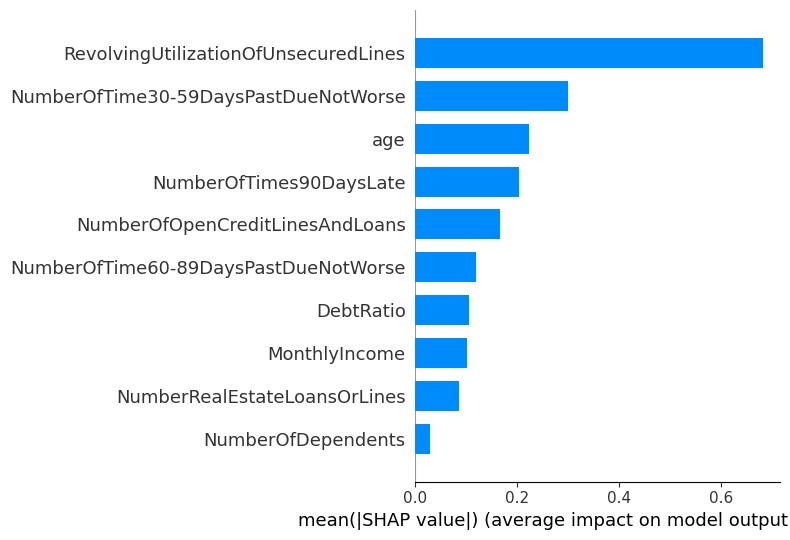


--- SHAP Summary Plot (Feature Impact on Model Output) ---


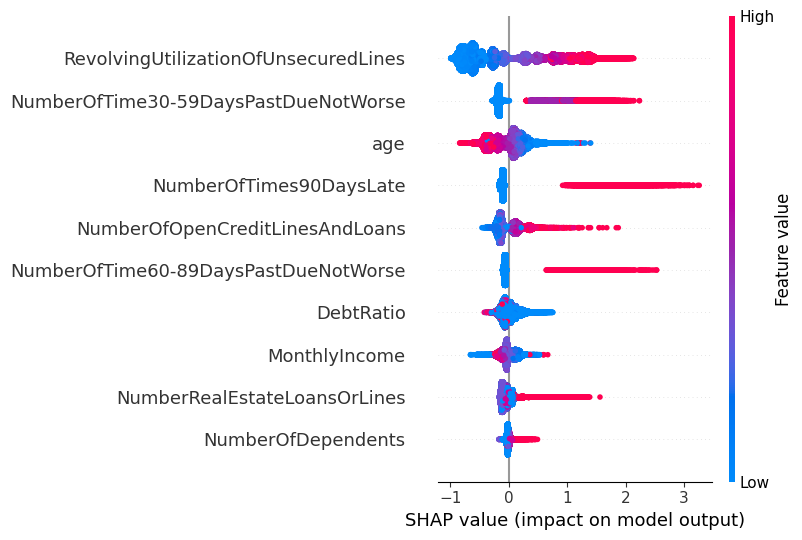

In [ ]:
# 9. Model Interpretability and Feature Attribution (SHAP)

# SHAP (SHapley Additive exPlanations) provides a robust, game-theoretic
# approach to explaining model predictions, which is crucial for transparency
# and trust in financial risk models.

print("\n--- Calculating SHAP values for model interpretation ---")
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

# SHAP provides feature importances based on the magnitude of feature attributions
print("\n--- Global Feature Importance (Mean Absolute SHAP Value) ---")
shap.summary_plot(shap_values, X_test, plot_type="bar")

print("\n--- SHAP Summary Plot (Feature Impact on Model Output) ---")
# This plot shows not only the importance but also the direction of the effect.
shap.summary_plot(shap_values, X_test)

---